## Table of contents <a id="contents"></a>

1. [Data Understanding](#understanding)
   - 4.1 [Initial Setup](#setup)
   - 4.2 [Tabular Data](#tabular)
   - 4.3 [CT Image Data](#image)
8. [References](#references)

## Data Understanding <a name="understanding"></a>
[go back to the top](#contents)

The dataset used for this project is the **LIDC-IDRI** collection.The Lung Image Database Consortium image collection (LIDC-IDRI) is a publicly accessible resource consisting of thoracic CT scans with annotated lesions, designed for the development, training, and evaluation of computer-aided diagnostic (CAD) systems for lung cancer. 
The dataset was created through the collaboration of seven academic centers and eight medical imaging companies and includes **1,018 cases**. Each case contains clinical thoracic CT images and an XML file detailing the results of a two-phase annotation process conducted by four experienced thoracic radiologists. In the first phase, radiologists independently reviewed each CT scan and marked lesions into three categories: **“nodule ≥3 mm,” “nodule <3 mm,” and “non-nodule ≥3 mm.”** In the second phase, the radiologists reviewed their own annotations along with the anonymized annotations from the other three radiologists to make a final assessment. This approach aimed to identify lung nodules comprehensively without requiring a consensus among radiologists. **[3]** The LIDC-IDRI dataset can be accessed through The Cancer Imaging Archive at the following link: [LIDC-IDRI Collection](https://www.cancerimagingarchive.net/collection/lidc-idri/).



In this section, we will conduct a comprehensive analysis of the LIDC-IDRI data to better understand the structure, content, and any potential issues within the different dataset files. This exploration is crucial to identify key characteristics and features, as well as to guide preprocessing steps before any model development.

### Initial Setup <a id="setup"></a>
[go back to the top](#contents)

To ensure a smooth development process, we have prepared a detailed guide outlining the steps to create a controlled virtual environment using conda. This guide addresses the compatibility issues we faced between various libraries and Python versions, providing precise instructions for setting up the environment. You can refer to the guide in the file **Environment_Setup_Guide.md**.

The code below imports all the necessary libraries for this project and prints their versions. This step helps verify that you are using the correct versions of each package, as specified in the guide, ensuring compatibility and reproducibility throughout the project.

In [2]:
import os

import sys
print("Python version:", sys.version)

import numpy as np
print("NumPy version:", np.__version__)

import matplotlib.pyplot as plt
import matplotlib as mpl 
print("Matplotlib version:", mpl.__version__)

import pylidc as pl
print("pylidc version:", pl.__version__)

import pandas as pd
print("pandas:", pd.__version__)

import radiomics
print("pyradiomics version:", radiomics.__version__)

import pydicom
print("pydicom version:", pydicom.__version__)

import sklearn
print("scikit-learn version:", sklearn.__version__)

from radiomics import featureextractor, getFeatureClasses

Python version: 3.8.19 (default, Mar 20 2024, 15:00:34) 
[Clang 14.0.6 ]
NumPy version: 1.23.5
Matplotlib version: 3.7.5
pylidc version: 0.2.3
pandas: 2.0.3
pyradiomics version: v3.1.0
pydicom version: 2.4.4
scikit-learn version: 1.3.2


### Tabular Data <a id="tabular"></a>
[go back to the top](#contents)

Upon exploring the **LIDC-IDRI_MetaData.csv** file, we noticed that it provides comprehensive metadata about each CT scan in the LIDC-IDRI dataset.

In [4]:
df = pd.read_csv("LIDC-IDRI_MetaData.csv")
df_sorted = df.sort_values(by='Subject ID')
df_sorted.head()

,Subject ID,Study UID,Study Description,Study Date,Series ID,Series Description,Number of images,File Size (Bytes),Collection Name,Modality,Manufacturer
348,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,NaN,2000-01-01 00:00:00.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,NaN,133,70018838,LIDC-IDRI,CT,GE MEDICAL SYSTEMS
186,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118...,NaN,2000-01-01 00:00:00.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818...,NaN,2,16357620,LIDC-IDRI,DX,GE MEDICAL SYSTEMS
1100,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...,NaN,2000-01-01 00:00:00.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...,NaN,1,6909958,LIDC-IDRI,DX,GE MEDICAL SYSTEMS
1141,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,NaN,2000-01-01 00:00:00.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,NaN,261,137396696,LIDC-IDRI,CT,GE MEDICAL SYSTEMS
189,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.202063331127...,NaN,2000-01-01 00:00:00.0,1.3.6.1.4.1.14519.5.2.1.6279.6001.142026812390...,NaN,5,38580794,LIDC-IDRI,DX,GE MEDICAL SYSTEMS


This dataset contains multiple imaging modalities, but our primary focus is on the **CT (Computed Tomography)** scans, which are crucial for lung nodule analysis. After filtering the data based on the **Modality** column, we found that there are **1,018 CT scans** in the dataset, from **1010 patients**. While these represent all the CT scans available, the dataset also includes other imaging modalities like DX or CR, which are not of interest for our current analysis.

In [5]:
# Filter rows where Modality is CT
df_ct = df[df['Modality'] == 'CT']

num_ct_scans = df_ct.shape[0]
print(f"Number of CT scans: {num_ct_scans}")

# Count the number of unique patients (Subject IDs)
num_unique_patients = df_ct['Subject ID'].nunique()
print(f"Number of unique patients with CT scans: {num_unique_patients}")

Number of CT scans: 1018
Number of unique patients with CT scans: 1010


To understand how the CT scans in the LIDC-IDRI dataset were acquired, we analyzed the **Manufacturer** column. This column indicates the type of equipment used for each scan, which provides insight into the variety of machines and settings used for image acquisition. This variability can affect the consistency and quality of the images.

GE MEDICAL SYSTEMS    670
SIEMENS               205
Philips                74
TOSHIBA                69
Name: Manufacturer, dtype: int64


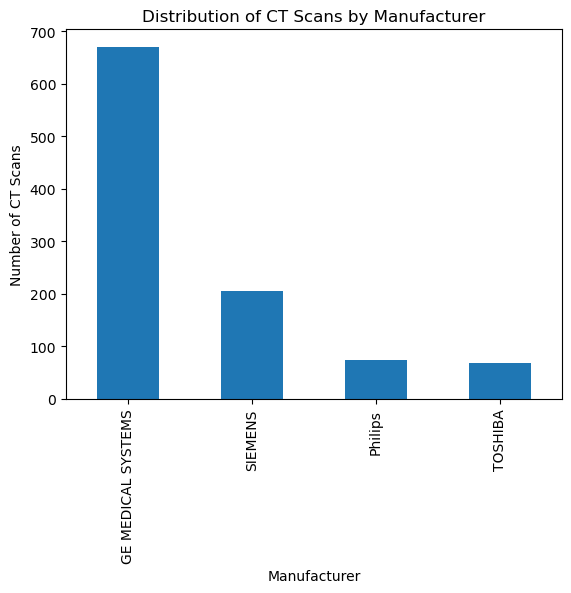

In [6]:
# Count the number of scans per manufacturer
manufacturer_counts = df_ct['Manufacturer'].value_counts()
print(manufacturer_counts)

manufacturer_counts.plot(kind='bar')
plt.xlabel('Manufacturer')
plt.ylabel('Number of CT Scans')
plt.title('Distribution of CT Scans by Manufacturer')
plt.show()

The file **tcia-diagnosis-data-2012-04-20.xls** contains several columns with diagnostic information at both the patient and nodule levels for the LIDC-IDRI dataset. Here is a summary of what each column represents:
- TCIA Patient ID: Unique identifier for each patient in the LIDC-IDRI dataset.
- Diagnosis at the Patient Level: A categorization of the overall diagnosis of the patient:
    - 0: Unknown diagnosis.
    - 1: Benign/non-malignant disease.
    - 2: Malignant primary lung cancer.
    - 3: Malignant metastatic disease.
- Diagnosis Method: The approach used to diagnose the patient's condition:
    - 0: Unknown.
    - 1: Radiological review.
    - 2: Biopsy.
    - 3: Cytology.
    - 4: Surgical resection.
- Primary Tumor Site for Metastatic Disease: If metastatic, specifies the primary site of the tumor.
- Nodule Diagnosis Columns (e.g., Nodule 1 to Nodule 5): Specific details for up to five nodules per patient, including diagnosis status and diagnosis method for each nodule.

In [7]:
#Ensure you have previously performed - pip install xlrd 

df1= pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')
df1_sorted= df1.sort_values(by= 'TCIA Patient ID')
df1_sorted.head()

,TCIA Patient ID,"Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n",Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response,Primary tumor site for metastatic disease,"Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 3\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 3\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 4\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 4\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 5\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 5\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Types of Lung Cancer (Malignant Primary Lung Cancer)**:

For rows where the "Diagnosis at the Patient Level" is marked as 2 (Malignant primary lung cancer), the cancer is localized to the lungs and may be of different types:

- **Non-Small Cell Lung Cancer (NSCLC)**: The most common type, accounting for around 85% of lung cancers. It includes subtypes such as:
    - Adenocarcinoma: Originates in mucus-secreting glands and is common among both smokers and non-smokers.
    - Squamous Cell Carcinoma: Begins in the lining of the lung airways and is strongly associated with smoking.
    - Large Cell Carcinoma: A less common type that can appear anywhere in the lung and tends to grow quickly.
- **Small Cell Lung Cancer (SCLC)**: More aggressive and accounts for around 15% of lung cancers. It often spreads quickly and is usually found in smokers.

For patients marked as having **metastatic disease** (3 in "Diagnosis at the Patient Level"), the Primary Tumor Site for Metastatic Disease column provides information on where the primary tumor originated before spreading to the lungs.

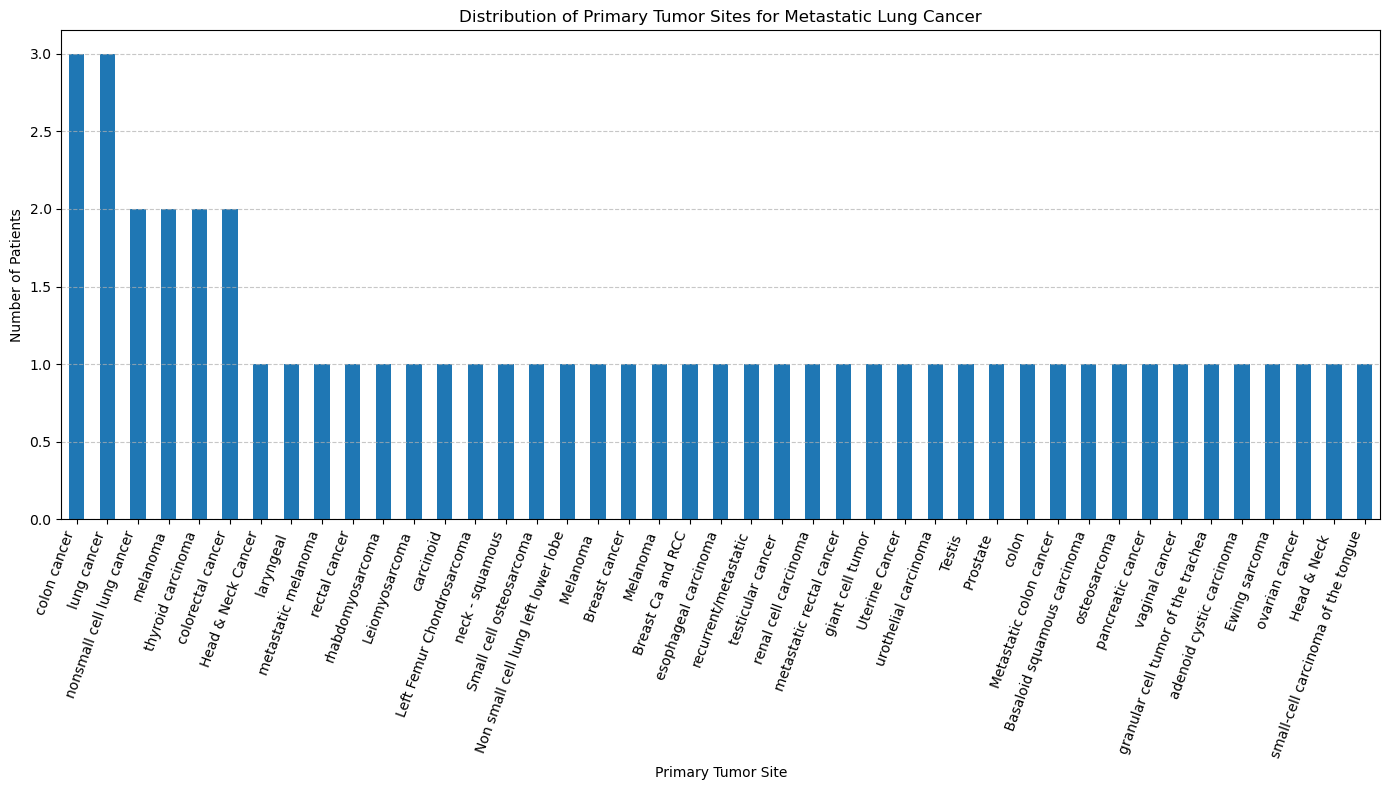

In [8]:
df = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')

# Filter rows where the value of the second column is 3
df_metastatic = df[df.iloc[:, 1] == 3]

# Count the primary tumor sites from the 'Primary Tumor Site for Metastatic Disease' column
primary_tumor_counts = df_metastatic['Primary tumor site for metastatic disease'].value_counts()

# Plot the distribution
plt.figure(figsize=(14, 8))  
primary_tumor_counts.plot(kind='bar')
plt.xlabel('Primary Tumor Site')
plt.ylabel('Number of Patients')
plt.title('Distribution of Primary Tumor Sites for Metastatic Lung Cancer')
plt.xticks(rotation=70, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show()

The chart highlights that some rows are marked as "3" (metastatic disease) under the "Diagnosis at the Patient Level," but the "Primary Tumor Site for Metastatic Disease" is labeled as a type of lung cancer. This is incoherent because these cases should be classified as "2" (primary lung cancer) rather than metastatic.

The file **lidc-idri-nodule-counts-6-23-2015.xlsx** provides a summary of the nodules identified within each patient in the LIDC-IDRI dataset.Here is an overview of the columns and the meaning of the notes (*, ** , *** ):
- TCIA Patient ID: Unique identifier for each patient whose scan was analyzed.
- Total Number of Nodules: The total count of nodules detected in a patient, regardless of size.
    - Note: This includes any lesion marked as either a "nodule < 3mm" or a "nodule >= 3mm" by at least one of the four LIDC radiologists.
- Number of Nodules >= 3mm: Count of nodules that are 3mm or larger.
    - Note: These nodules were marked as "nodule >= 3mm" by at least one of the four LIDC radiologists, irrespective of the markings by the other radiologists.
- Number of Nodules < 3mm: Count of nodules smaller than 3mm.
    - Note: These are nodules that were specifically marked as "nodule < 3mm" by at least one radiologist, without any other radiologist marking them as "nodule >= 3mm."

In [30]:
#Ensure you have already performed - pip install openpyxl

df2= pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')
df2_sorted= df2.sort_values(by= 'TCIA Patent ID')
df2_sorted.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


The next bar plot displays the overall distribution of nodule sizes across all patients in the dataset. The data is divided into two categories. The plot shows that nodules < 3mm are more prevalent than those >= 3mm, suggesting that smaller nodules are more commonly identified across the dataset.

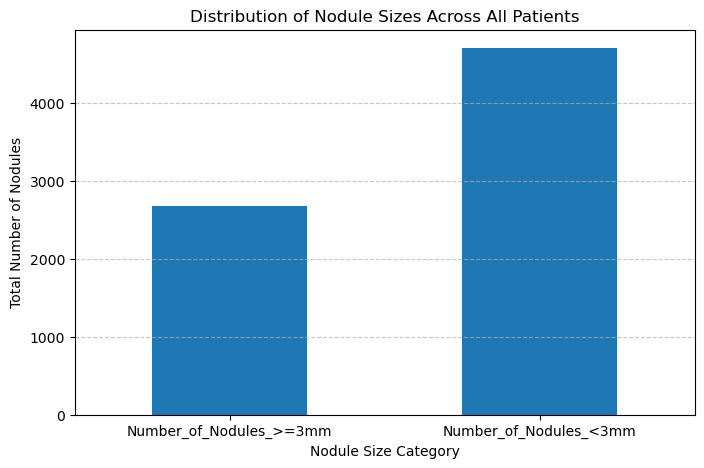

In [34]:
df2_filtered = df2_sorted[df2_sorted['TCIA_Patent_ID'].notna()]

df2_filtered.columns = df2_filtered.columns.str.strip().str.replace('*', '', regex=False).str.replace(' ', '_')

size_distribution = df2_filtered[['Number_of_Nodules_>=3mm', 'Number_of_Nodules_<3mm']].sum()

plt.figure(figsize=(8, 5))
size_distribution.plot(kind='bar')
plt.xlabel('Nodule Size Category')
plt.ylabel('Total Number of Nodules')
plt.title('Distribution of Nodule Sizes Across All Patients')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The next bar plot identifies the top 10 patients who have the highest total count of nodules in their scans. Each bar represents a patient, labeled by their unique "TCIA Patient ID". The plot reveals that a few patients have notably higher nodule counts (with some exceeding 50 nodules), which significantly deviates from the general distribution observed in the larger dataset. 

The average (mean) number of nodules per patient is: 7.24
The standard deviation is: 8.35


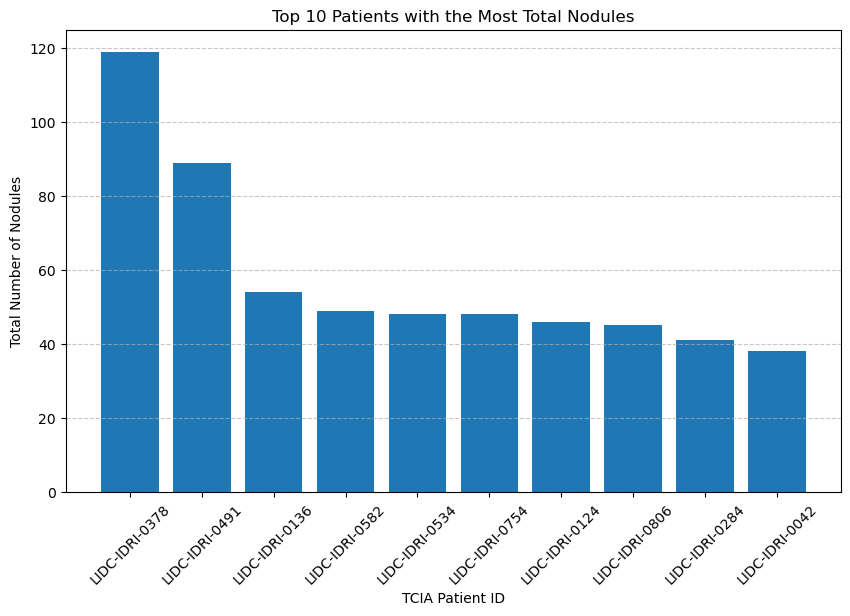

In [38]:
df2_filtered = df2_sorted[df2_sorted['TCIA_Patent_ID'].notna()].copy()  # Make a copy to avoid SettingWithCopyWarning

df2_filtered.columns = df2_filtered.columns.str.strip().str.replace('*', '', regex=False).str.replace(' ', '_')

df2_filtered.loc[:, 'Total_Number_of_Nodules'] = pd.to_numeric(df2_filtered['Total_Number_of_Nodules'], errors='coerce')

top_patients = df2_filtered.nlargest(10, 'Total_Number_of_Nodules')

mean_nodules = df2_filtered['Total_Number_of_Nodules'].mean()
std_nodules = df2_filtered['Total_Number_of_Nodules'].std()

print(f"The average (mean) number of nodules per patient is: {mean_nodules:.2f}")
print(f"The standard deviation is: {std_nodules:.2f}")

plt.figure(figsize=(10, 6))
plt.bar(top_patients['TCIA_Patent_ID'], top_patients['Total_Number_of_Nodules'])
plt.xlabel('TCIA Patient ID')
plt.ylabel('Total Number of Nodules')
plt.title('Top 10 Patients with the Most Total Nodules')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### CT Image Data <a id="image"></a>
[go back to the top](#contents)

As suggested in **[3]**, we started by using pylidc (https://pylidc.github.io/) **[4]**, a Python library designed for analyzing lung nodules in CT scans from the Lung Image Database Consortium (LIDC). This library efficiently loads and manages images and annotations from the LIDC-IDRI dataset, extracts features for detailed analysis of lung nodules, and displays CT scans, segmentations, and annotations for better interpretation.

In this Python script, we extract important imaging details for a patient, including pixel spacing, slice thickness, and slice spacing.  

In [44]:
scans = pl.query(pl.Scan).all()

# Print the total number of scans in the dataset
print(f"Total number of scans retrieved: {len(scans)}")

# Print the first scan object information
print(f"First scan object: {scans[0]}")

# Select the first scan from the list of scans
first_scan = scans[0]

print(f"Patient ID: {first_scan.patient_id}")
print(f"Slice Thickness: {first_scan.slice_thickness}")  
print(f"Pixel Spacing: {first_scan.pixel_spacing}")  
print(f"Slice Spacing: {first_scan.slice_spacing}")  

# Print the number of annotations from the first scan
print(f"Number of annotations on the patient {first_scan.patient_id}: {len(first_scan.annotations)}")

Total number of scans retrieved: 1018
First scan object: Scan(id=1,patient_id=LIDC-IDRI-0078)
Patient ID: LIDC-IDRI-0078
Slice Thickness: 3.0
Pixel Spacing: 0.65
Slice Spacing: 3.0
Number of annotations on the patient LIDC-IDRI-0078: 13


The **slice thickness** indicates how much tissue is represented in a single image slice. While the current output shows a slice thickness of 3.0 mm, it's important to note that modern imaging techniques often achieve slice thicknesses as small as 1 mm or even 0.5 mm, offering significantly higher resolution and more detailed anatomical insights

**Pixel spacing**, which represents the physical distance between the centers of two adjacent pixels, is crucial for determining the spatial resolution of the images. Smaller pixel spacing values enhance the image's detail, allowing for clearer visualization of small structures. 

**Slice spacing**, the distance between consecutive slices, is also a critical factor. Ideally, slice spacing should be equal to or less than the slice thickness to avoid gaps in the data and ensure that the reconstructed volume accurately represents the patient's anatomy. 

However, only 92 scans out of 1018 meet the desired criteria:

In [45]:
# Print number of scans that have a slice thickness of ≤1 mm and where the pixel spacing ≤ slice thicknes
example = pl.query(pl.Scan).filter(pl.Scan.slice_thickness <= 1, pl.Scan.pixel_spacing <= pl.Scan.slice_thickness)
count = example.count()
print(f"Number of scans that meet the recommended criteria: {count}")

Number of scans that meet the recommended criteria: 92


The next script retrieves all annotations for a specific CT scan. It then collects details like the centroid, diameter, volume, and surface area for each annotation and displays them in a table.

In [50]:
# Get the list of annotations for the first scan
annotations = scans[0].annotations

# Print the number of annotations
print(f"Number of annotations for scan {scans[0].patient_id}: {len(annotations)}")

# Create a list to store annotation details
annotation_data = []

# Loop through each annotation and collect its details
for i, annotation in enumerate(annotations, 1):
    annotation_data.append({
        "Annotation ID": i,
        "Center (x, y, z)": [round(coord, 2) for coord in annotation.centroid],  # Round centroid coordinates
        "Diameter (mm)": round(annotation.diameter, 2),
        "Volume (mm^3)": round(annotation.volume, 2),
        "Surface Area (mm^2)": round(annotation.surface_area, 2)
    })

# Convert the list of annotation details to a pandas DataFrame
df_annotations = pd.DataFrame(annotation_data)

# Display the table
print(df_annotations)

Number of annotations for scan LIDC-IDRI-0078: 13
    Annotation ID         Center (x, y, z)  Diameter (mm)  Volume (mm^3)  \
0               1    [169.2, 360.81, 46.2]          20.84        2439.30   
1               2  [312.31, 331.91, 25.65]          19.50        2621.82   
2               3  [245.08, 340.54, 67.55]          23.30        4332.31   
3               4  [244.65, 341.29, 67.47]          32.81        5230.34   
4               5  [169.21, 360.82, 46.22]          20.89        2443.74   
5               6  [309.92, 328.61, 25.41]          27.65        2703.58   
6               7  [244.03, 341.75, 67.82]          28.67        4554.13   
7               8  [348.83, 336.42, 47.42]           5.08          62.11   
8               9  [168.86, 361.05, 46.28]          23.54        1510.23   
9              10  [309.88, 327.92, 25.17]          27.98        2260.59   
10             11  [245.59, 341.53, 67.67]          26.00        5365.96   
11             12   [171.0, 361.26, 46

The following code snippet demonstrates how annotations from a CT scan can be clustered into nodules. In the LIDC-IDRI dataset, each nodule is characterized by one or more annotations, which represent different interpretations by the radiologists. However, a nodule is typically annotated by up to four radiologists, meaning that there can be one to four annotations per nodule. To identify which annotations belong to the same nodule, we use the pylidc library's cluster_annotations() method.

As described in the pylidc documentation:

"The scan has 13 annotations, but which refer to the same nodule? This can be determined using the pylidc.Scan.cluster_annotations() method, which uses a distance function to create an adjacency graph to determine which annotations refer to the same nodule in a scan" [4].

This clustering method groups annotations based on spatial proximity and other properties, aiming to represent each unique nodule. Below is an example of clustering annotations for the first patient in the dataset:

In [52]:
nods = scans[0].cluster_annotations()
print("%s has %d nodules." % (scans[0], len(nods)))

for i,nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))

Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.
Nodule 4 has 4 annotations.


However, we observed that this method does not always perform as expected. In some cases, the clustering algorithm does not correctly group annotations, resulting in nodules with more than four annotations, which may require manual correction. For instance, consider the following case for a different patient:

In [71]:
nods = scans[65].cluster_annotations()
print("%s has %d nodules." % (scans[65], len(nods)))

for i,nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Scan(id=66,patient_id=LIDC-IDRI-0055) has 7 nodules.
Nodule 1 has 6 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 2 annotations.
Nodule 4 has 1 annotations.
Nodule 5 has 4 annotations.
Nodule 6 has 1 annotations.
Nodule 7 has 2 annotations.


The following snippet dives deeper into the clustered nodules. For each nodule, it loops through its annotations and prints details, allowing to understand the individual annotations that make up each nodule.

In [53]:
# Cluster the annotations into nodules for the first scan
nods = scans[0].cluster_annotations()

print(f"{scans[0]} has {len(nods)} nodules.")

# Create a list to store details about nodules and their annotations
nodule_data = []

# Loop through each nodule and its annotations
for i, nod in enumerate(nods):
    nodule_id = i + 1
    num_annotations = len(nod)
    
    for j, annotation in enumerate(nod):
        annotation_id = j + 1
        nodule_data.append({
            "Nodule ID": nodule_id,
            "Annotation ID": annotation_id,
            "Number of Annotations": num_annotations,
            "Center (x, y, z)": [round(coord, 2) for coord in annotation.centroid],
            "Diameter (mm)": round(annotation.diameter, 2),
            "Volume (mm^3)": round(annotation.volume, 2),
            "Surface Area (mm^2)": round(annotation.surface_area, 2)
        })

# Convert the list of details into a pandas DataFrame
df_nodules = pd.DataFrame(nodule_data)

# Display the DataFrame as a table
print(df_nodules)


Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
    Nodule ID  Annotation ID  Number of Annotations         Center (x, y, z)  \
0           1              1                      4  [312.31, 331.91, 25.65]   
1           1              2                      4  [309.92, 328.61, 25.41]   
2           1              3                      4  [309.88, 327.92, 25.17]   
3           1              4                      4  [313.88, 332.56, 25.48]   
4           2              1                      4    [169.2, 360.81, 46.2]   
5           2              2                      4  [169.21, 360.82, 46.22]   
6           2              3                      4  [168.86, 361.05, 46.28]   
7           2              4                      4   [171.0, 361.26, 46.44]   
8           3              1                      1  [348.83, 336.42, 47.42]   
9           4              1                      4  [245.08, 340.54, 67.55]   
10          4              2                      4  [244.65, 341.29

The next script selects the first nodule of the first patient and visualizes its individual annotations in 3D.

Visualizing Annotation 1 of Nodule 1


/home/vitordrferreira/miniconda3/envs/pylidc_env/lib/python3.7/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
/home/vitordrferreira/miniconda3/envs/pylidc_env/lib/python3.7/site-packages/pylidc/Annotation.py:764: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  facecolors=plt.cm.cmap_d[cmap](t))


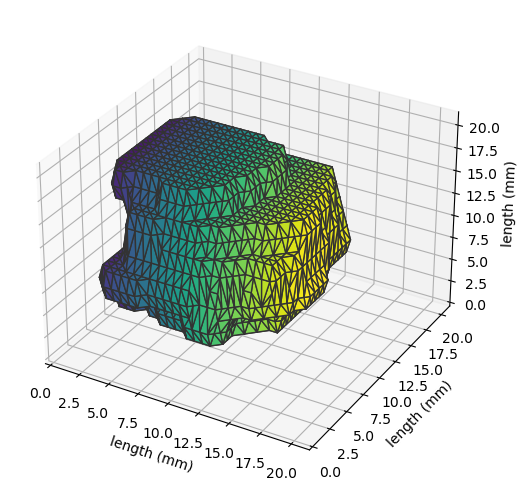

Visualizing Annotation 2 of Nodule 1


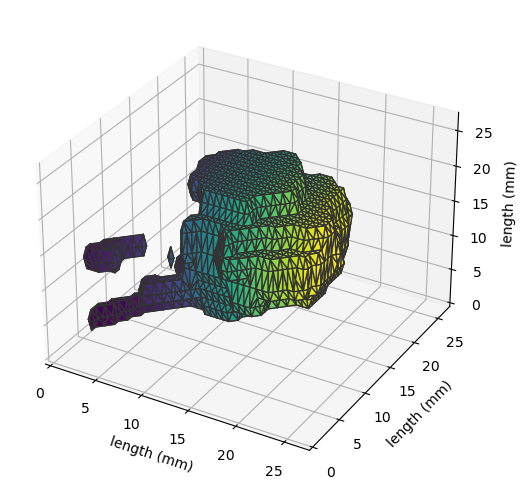

Visualizing Annotation 3 of Nodule 1


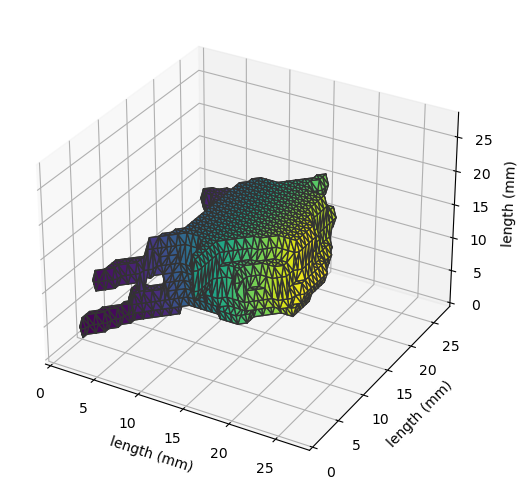

Visualizing Annotation 4 of Nodule 1


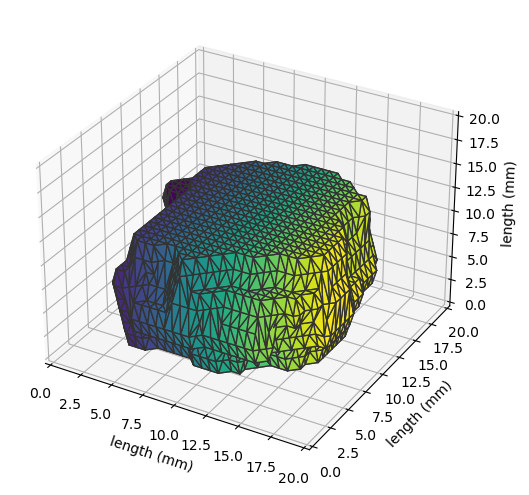

In [66]:
# Patient ID for the first patient
pid = 'LIDC-IDRI-0078'

# Query the scan for the patient
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

# Cluster annotations into nodules
nodules = scan.cluster_annotations()

# Select the first nodule (index 0) and its annotations
first_nodule = nodules[0]
annotations = list(first_nodule)  # List of annotations for the first nodule

# Loop through each annotation and visualize it separately in 3D
for i, annotation in enumerate(annotations):
    print(f"Visualizing Annotation {i+1} of Nodule 1")
    annotation.visualize_in_3d()

The following table provides a summary of the annotation features available in the pylidc library for lung nodule characterization in the LIDC-IDRI dataset. Each nodule in a CT scan is annotated by radiologists, with several features describing its visual and morphological properties. These features are represented as integer values ranging from 1 to 5 (or 6 in some cases), which are then mapped to descriptive categories.

This table lists each feature alongside its possible integer values and their corresponding descriptions. The descriptions help interpret the raw numeric data and provide meaningful insights into the nodule's characteristics.

| **Feature**           | **Int Values & Descriptions**                                            |
|-----------------------|--------------------------------------------------------------------------|
| **Subtlety**          | 1: Extremely Subtle, 2: Moderately Subtle, 3: Fairly Subtle, 4: Moderately Obvious, 5: Obvious |
| **Internal Structure**| 1: Soft Tissue, 2: Fluid, 3: Fat, 4: Air                                 |
| **Calcification**     | 1: Popcorn, 2: Laminated, 3: Solid, 4: Non-central, 5: Absent, 6: Central |
| **Sphericity**        | 1: Linear, 2: Ovoid/Linear, 3: Ovoid, 4: Ovoid/Round, 5: Round           |
| **Margin**            | 1: Poorly Defined, 2: Near Poorly Defined, 3: Medium Margin, 4: Near Sharp, 5: Sharp |
| **Lobulation**        | 1: No Lobulation, 2: Nearly No Lobulation, 3: Medium Lobulation, 4: Near Marked Lobulation, 5: Marked Lobulation |
| **Spiculation**       | 1: No Spiculation, 2: Nearly No Spiculation, 3: Medium Spiculation, 4: Near Marked Spiculation, 5: Marked Spiculation |
| **Texture**           | 1: Non-Solid/GGO, 2: Non-Solid/Mixed, 3: Part Solid/Mixed, 4: Solid/Mixed, 5: Solid |
| **Malignancy**        | 1: Highly Unlikely, 2: Moderately Unlikely, 3: Indeterminate, 4: Moderately Suspicious, 5: Highly Suspicious |



Certain attributes are categorized as non-ordinal due to the nature of their measurement. Non-ordinal attributes are qualitative characteristics that lack a meaningful order or ranking. Instead, they represent distinct categories describing the features of nodules identified in imaging studies. The non-ordinal features include Internal Structure and Calcification. [artigo 8]

The LIDC-IDRI dataset comes with metadata, which provides information about the CT scans, including file locations, patient IDs, and series UIDs. The metadata is loaded into a pandas DataFrame to facilitate access to this information.

In [72]:
meta= pd.read_csv('metadata.csv')
meta.head(1)

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
1.3.6.1.4.1.14519.5.2.1.6279.6001.154145395981214039394434950814,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0011,1.3.6.1.4.1.14519.5.2.1.6279.6001.129840843404...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,DX,Digital X-Ray Image Storage - For Presentation,1.2.840.10008.5.1.4.1.1.1.1,2,15,20 MB,./LIDC-IDRI/LIDC-IDRI-0011/01-01-2000-NA-NA-55...,2024-09-26T19:16:51.099


Next, we extract the directory containing the DICOM files for a specific scan.

In [73]:
dir = meta.iloc[3]['File Location']
dir

'./LIDC-IDRI/LIDC-IDRI-0069/01-01-2000-NA-NA-29787/3079.000000-NA-04249'

To visualize the CT images, we use pydicom to read the DICOM files. Each CT scan is composed of multiple slices, each saved as a DICOM file. Here, we load two slices (index 001 and 114) for visualization purposes.

The pixel array values are transformed into Hounsfield Units (HU), which is the standard unit for CT imaging. This is achieved using the RescaleSlope and RescaleIntercept values from the DICOM header, which adjust the pixel intensity values.

In [74]:
CT_folder = os.path.join(dir)
ct1 = pydicom.read_file(os.path.join(CT_folder, '1-001.dcm'))
ct2 = pydicom.read_file(os.path.join(CT_folder, '1-114.dcm'))
image1 = ct1.pixel_array
image2 = ct2.pixel_array
image1 = ct1.RescaleSlope * image1 + ct1.RescaleIntercept
image2 = ct2.RescaleSlope * image2 + ct2.RescaleIntercept

The transformed slices are visualized using Matplotlib, with a grayscale colormap (Greys_r). Each visualization includes a colorbar indicating the range of Hounsfield Units.

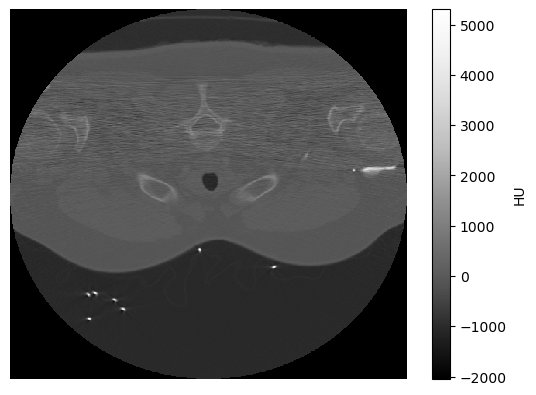

In [75]:
plt.pcolormesh(image1, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

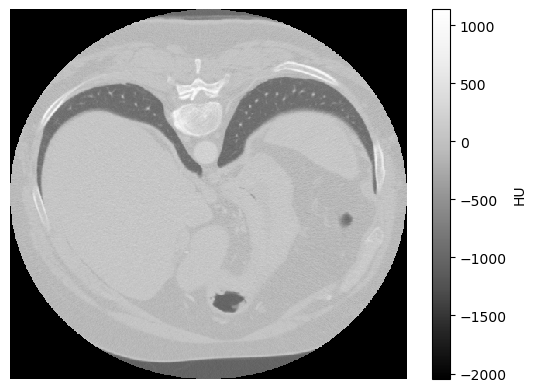

In [76]:
plt.pcolormesh(image2, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

Number of nodules for LIDC-IDRI-0078: 4
Loading dicom files ... This may take a moment.
Number of images loaded for LIDC-IDRI-0078: 87
Loading dicom files ... This may take a moment.


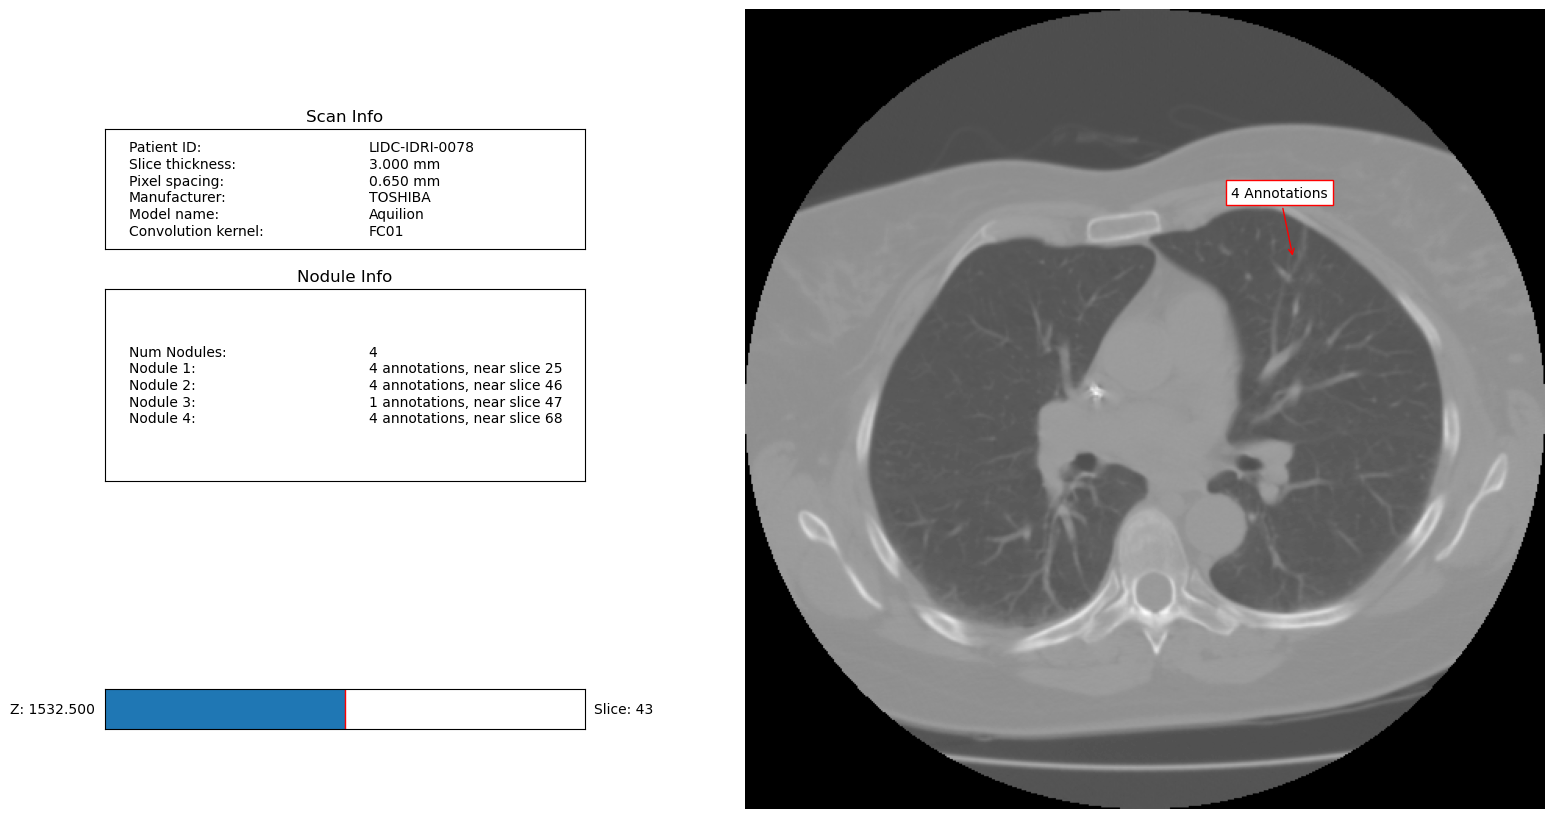

In [7]:
# Specify the Patient ID
patient_id = 'LIDC-IDRI-0078'

# Query the scan for the given patient
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()

# Cluster annotations into nodules
nodules = scan.cluster_annotations()  # Define `nodules` properly

# Print the number of nodules
print(f"Number of nodules for {patient_id}: {len(nodules)}")

# Load all DICOM images for the scan
images = scan.load_all_dicom_images()
print(f"Number of images loaded for {patient_id}: {len(images)}")

# Visualize the scan with the nodules
scan.visualize(annotation_groups=nodules)

## References <a name="references"></a>
[[go back to the top]](#references)

**[3]** Armato III, S. G., McLennan, G., Bidaut, L., McNitt-Gray, M. F., Meyer, C. R., Reeves, A. P., Zhao, B., Aberle, D. R., Henschke, C. I., Hoffman, E. A., Kazerooni, E. A., MacMahon, H., Van Beek, E. J. R., Yankelevitz, D., Biancardi, A. M., Bland, P. H., Brown, M. S., Engelmann, R. M., Laderach, G. E., Max, D., Pais, R. C. , Qing, D. P. Y. , Roberts, R. Y., Smith, A. R., Starkey, A., Batra, P., Caligiuri, P., Farooqi, A., Gladish, G. W., Jude, C. M., Munden, R. F., Petkovska, I., Quint, L. E., Schwartz, L. H., Sundaram, B., Dodd, L. E., Fenimore, C., Gur, D., Petrick, N., Freymann, J., Kirby, J., Hughes, B., Casteele, A. V., Gupte, S., Sallam, M., Heath, M. D., Kuhn, M. H., Dharaiya, E., Burns, R., Fryd, D. S., Salganicoff, M., Anand, V., Shreter, U., Vastagh, S., Croft, B. Y., Clarke, L. P. (2015). Data From LIDC-IDRI [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX

**[4]** Hancock, D. pylidc: A Python library for working with the LIDC-IDRI. https://pylidc.github.io (Accessed: 6/10/2024).